In [1]:
import os
import pickle
import numpy as np
from scipy import io
from mne import viz, stats
from matplotlib import colors, gridspec, pyplot as plt

In [2]:
CAF_DOSE = 200
SIGNIFICANT_P = 0.05

PROJECT_PATH = '..\\data' # path to where the EEG sensor position file is stored
RESULTS_PATH = '..\\results'
FIGURE_PATH = '..\\figures'

STAGES = ['AWSL', 'NREM', 'REM']
BANDS = ['delta', 'theta', 'alpha', 'sigma', 'beta', 'low gamma']
CHANNELS = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'C3', 'C4', 'P3 ', 'P4',
            'O1', 'O2 ', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'Oz']

In [3]:
# load EEG sensor positions to be used in the topomaps
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [4]:
with open(os.path.join(RESULTS_PATH, 'difference', f'total{CAF_DOSE}.pickle'), 'rb') as file:
    diff = pickle.load(file)

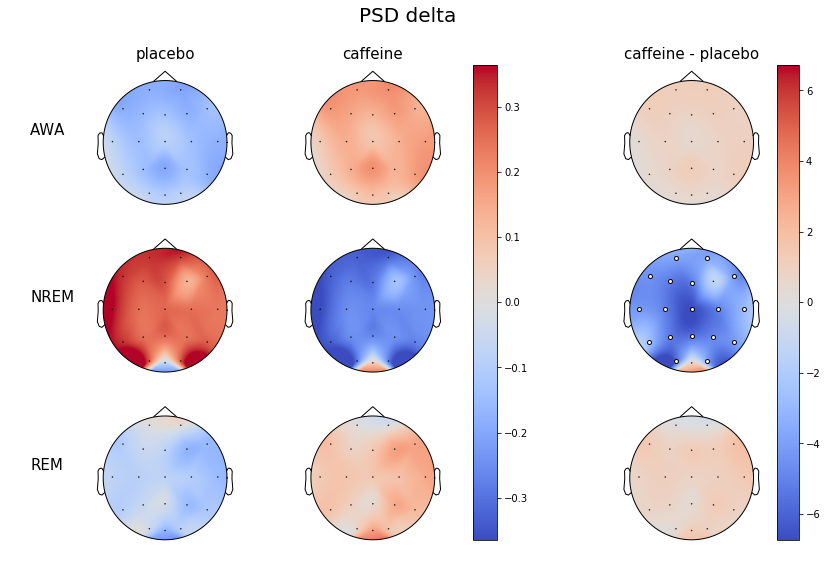

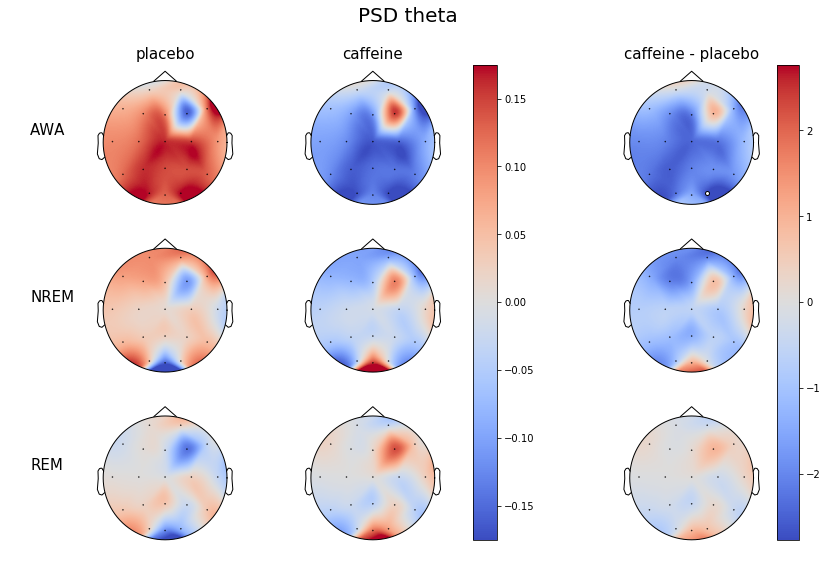

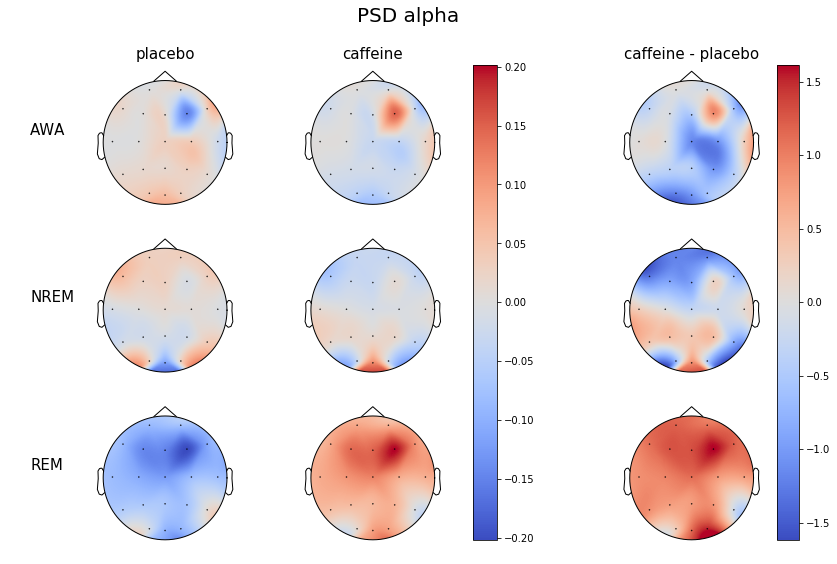

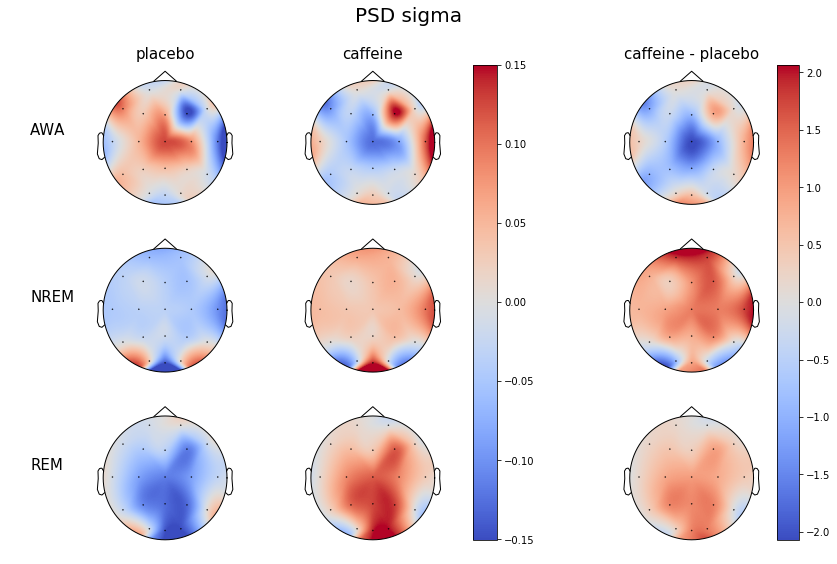

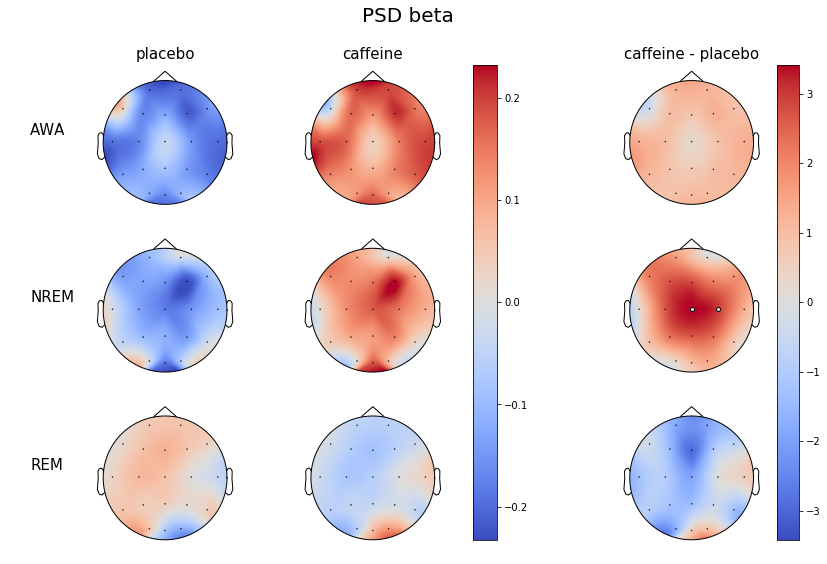

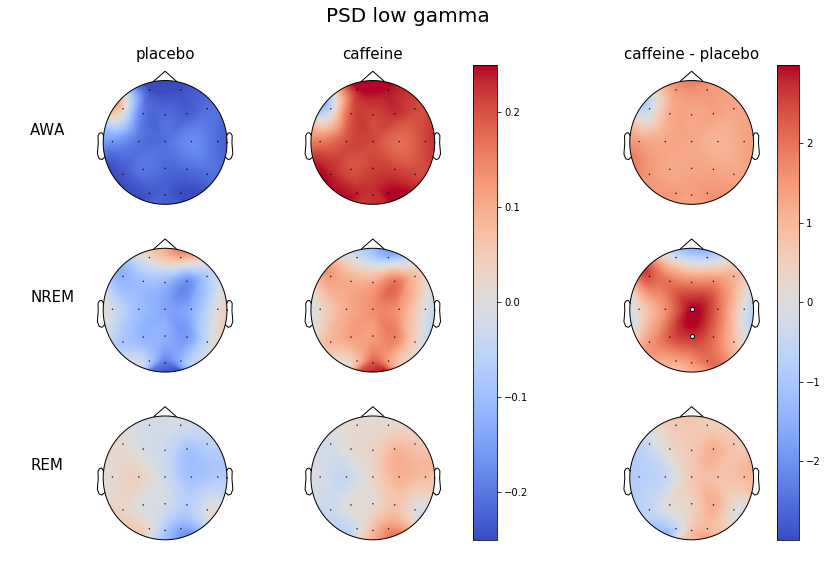

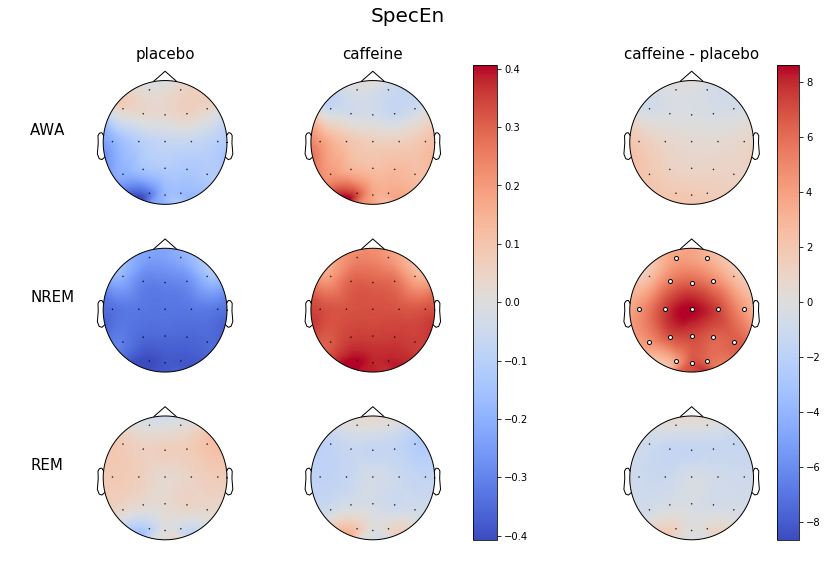

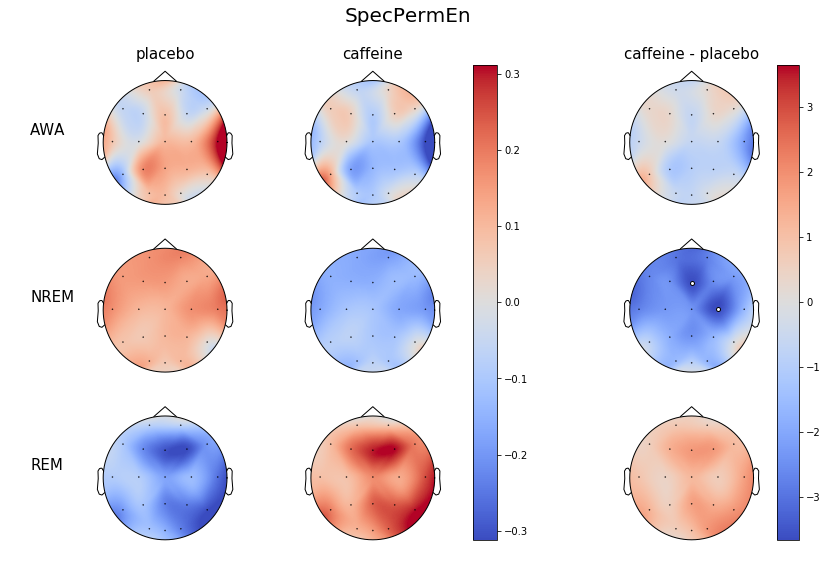

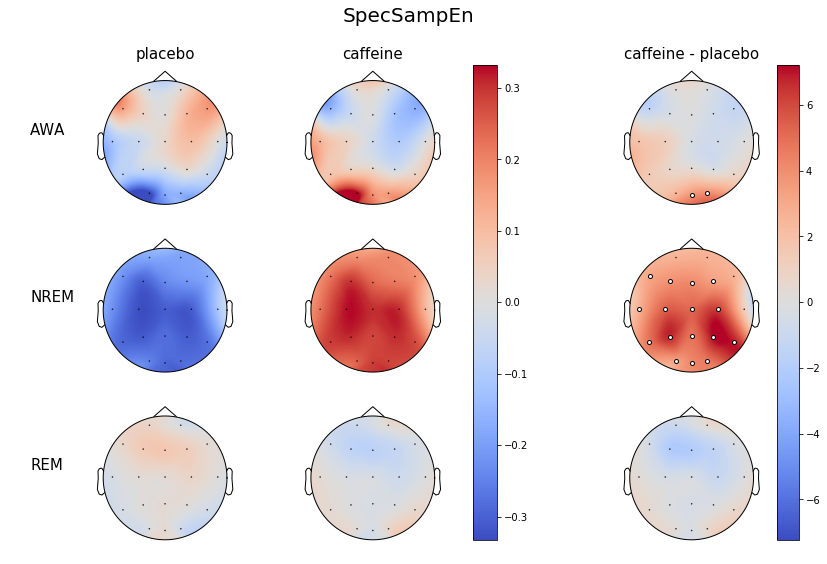

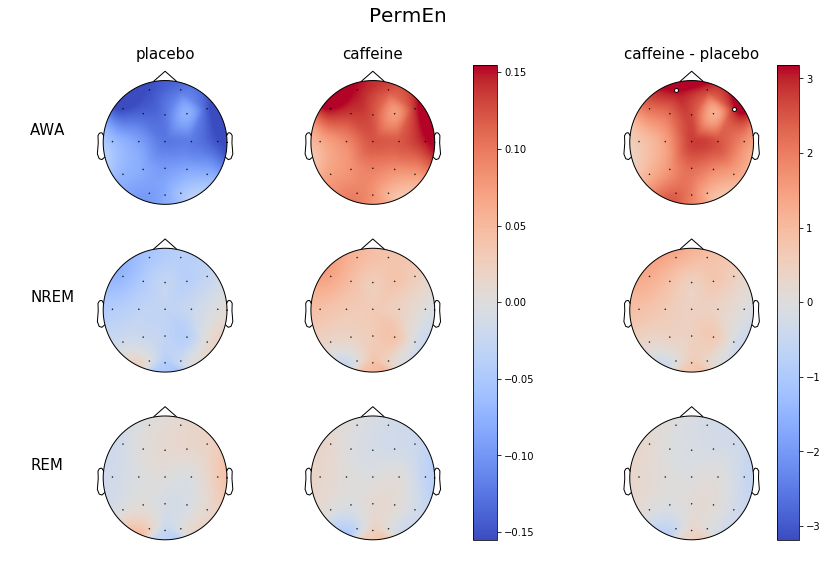

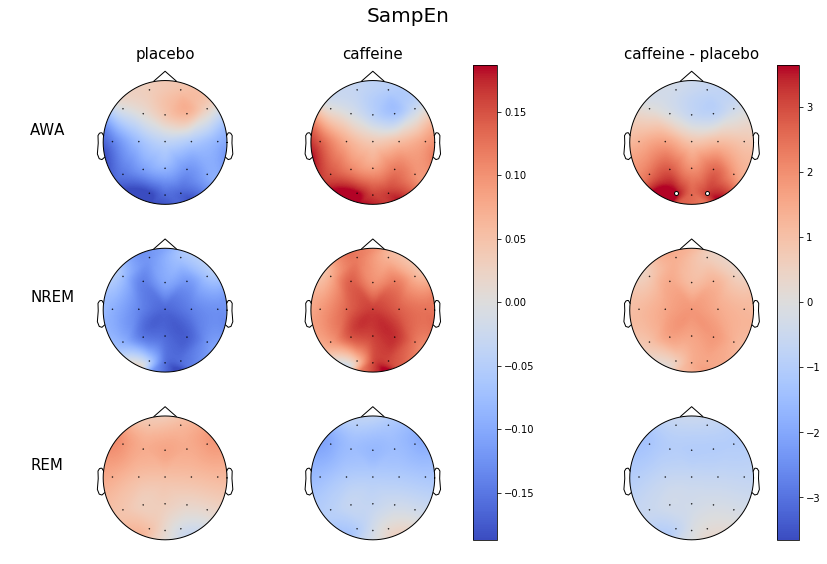

In [5]:
colormap = 'coolwarm'
small_font = 15
big_font = 20

for feature in diff[STAGES[0]].keys():
    vmin_mean = np.min([min(np.min(diff[stage][feature]['plac_mean']), np.min(diff[stage][feature]['caf_mean'])) for stage in STAGES])
    vmax_mean = np.max([max(np.max(diff[stage][feature]['plac_mean']), np.max(diff[stage][feature]['caf_mean'])) for stage in STAGES])
    vmin_mean = -max(abs(vmin_mean), abs(vmax_mean))
    vmax_mean = max(abs(vmin_mean), abs(vmax_mean))
    
    vmin_t = np.min([np.min(diff[stage][feature]['t_statistic']) for stage in STAGES])
    vmax_t = np.max([np.max(diff[stage][feature]['t_statistic']) for stage in STAGES])
    vmin_t = -max(abs(vmin_t), abs(vmax_t))
    vmax_t = max(abs(vmin_t), abs(vmax_t))
    
    plt.figure(figsize=(14, 8))
    suptitle = plt.suptitle(feature.replace('_', ' ').replace('SpecShanEn', 'SpecEn'), fontsize=big_font, y=1.05)
    
    subplot_counter = 0
    gs = gridspec.GridSpec(len(STAGES), 4, width_ratios=[0.01, 1, 1, 1])
    
    mean_cbar_axes = []
    t_cbar_axes = []
    
    for stage in STAGES:
        # row annotation
        mean_cbar_axes.append(plt.subplot(gs[subplot_counter]))
        plt.annotate(stage.replace('AWSL', 'AWA'), xy=(0, 0.5), fontsize=small_font)
        plt.axis('off')
        subplot_counter += 1
        
        # placebo mean
        mean_cbar_axes.append(plt.subplot(gs[subplot_counter]))
        if stage == STAGES[0]:
            plt.title('placebo', fontsize=small_font)
        viz.plot_topomap(diff[stage][feature]['plac_mean'], sensor_pos, vmin=vmin_mean, vmax=vmax_mean, cmap=colormap, contours=False, show=False)
        subplot_counter += 1
        
        # caffeine mean
        mean_cbar_axes.append(plt.subplot(gs[subplot_counter]))
        if stage == STAGES[0]:
            plt.title('caffeine', fontsize=small_font)
        viz.plot_topomap(diff[stage][feature]['caf_mean'], sensor_pos, vmin=vmin_mean, vmax=vmax_mean, cmap=colormap, contours=False, show=False)
        subplot_counter += 1
        
        # caffeine - placebo t-statistic
        t_cbar_axes.append(plt.subplot(gs[subplot_counter]))
        if stage == STAGES[0]:
            plt.title('caffeine - placebo', fontsize=small_font)
        mask = diff[stage][feature]['p_value'] < SIGNIFICANT_P
        viz.plot_topomap(diff[stage][feature]['t_statistic'], sensor_pos, mask=mask, vmin=vmin_t, vmax=vmax_t, cmap=colormap, contours=False, show=False)
        subplot_counter += 1
    
    norm = colors.Normalize(vmin=vmin_mean, vmax=vmax_mean)
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=mean_cbar_axes, shrink=1, aspect=20)
    
    norm = colors.Normalize(vmin=vmin_t, vmax=vmax_t)
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=t_cbar_axes, shrink=1, aspect=22)
    
    plt.savefig(os.path.join(FIGURE_PATH, f'difference{CAF_DOSE}', f'{feature}'), bbox_inches='tight', bbox_extra_artists=[suptitle])
    plt.show()